In [208]:

import torch
import torchvision
from torchvision import transforms
from torchinfo import summary

from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [209]:
import cv2
from matplotlib import pyplot as plt

In [210]:
coco_names = ["person" , "bicycle" , "car" , "motorcycle" , "airplane" , "bus" , "train" , "truck" , "boat" , "traffic light" , "fire hydrant" , "street sign" , "stop sign" , "parking meter" , "bench" , "bird" , "cat" , "dog" , "horse" , "sheep" , "cow" , "elephant" , "bear" , "zebra" , "giraffe" , "hat" , "backpack" , "umbrella" , "shoe" , "eye glasses" , "handbag" , "tie" , "suitcase" , 
"frisbee" , "skis" , "snowboard" , "sports ball" , "kite" , "baseball bat" , 
"baseball glove" , "skateboard" , "surfboard" , "tennis racket" , "bottle" , 
"plate" , "wine glass" , "cup" , "fork" , "knife" , "spoon" , "bowl" , 
"banana" , "apple" , "sandwich" , "orange" , "broccoli" , "carrot" , "hot dog" ,
"pizza" , "donut" , "cake" , "chair" , "couch" , "potted plant" , "bed" ,
"mirror" , "dining table" , "window" , "desk" , "toilet" , "door" , "tv" ,
"laptop" , "mouse" , "remote" , "keyboard" , "cell phone" , "microwave" ,
"oven" , "toaster" , "sink" , "refrigerator" , "blender" , "book" ,
"clock" , "vase" , "scissors" , "teddy bear" , "hair drier" , "toothbrush" , "hair brush"]

# Создание модели


In [211]:
model = torchvision.models.detection.ssd300_vgg16(weights='SSD300_VGG16_Weights.DEFAULT')


In [71]:
summary(model, 
        input_size=(1, 3, 300, 300), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        row_settings=["var_names"]
)


Layer (type (var_name))                                 Input Shape               Output Shape              Param #                   Trainable
SSD (SSD)                                               [1, 3, 300, 300]          [87, 4]                   --                        Partial
├─GeneralizedRCNNTransform (transform)                  [1, 3, 300, 300]          [1, 3, 300, 300]          --                        --
├─SSDFeatureExtractorVGG (backbone)                     [1, 3, 300, 300]          [1, 256, 1, 1]            512                       Partial
│    └─Sequential (features)                            [1, 3, 300, 300]          [1, 512, 38, 38]          --                        Partial
│    │    └─Conv2d (0)                                  [1, 3, 300, 300]          [1, 64, 300, 300]         (1,792)                   False
│    │    └─ReLU (1)                                    [1, 64, 300, 300]         [1, 64, 300, 300]         --                        --
│    │    └─Conv

In [212]:
model = model.to(device)
model.eval()

SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

# Функция чтения и предобработки изображения

In [215]:

#resize = transforms.Resize((300, 300))
to_tensor = transforms.ToTensor()
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

def read_image(path):
    return cv2.imread(path)

def prepare_image(image):
    
    
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    im_pil = Image.fromarray(img)
    #image = normalize(to_tensor(im_pil))
    image = to_tensor(im_pil)
    
    image = image.to(device)
    return image
   
    



# Функция детекция объектов на изображении

In [216]:
def detect(image, thresh = 0.5):
     # Forward prop.
    predicteds = model(image.unsqueeze(0))
    bboxes, scores, labels = predicteds[0]["boxes"], predicteds[0]["scores"], predicteds[0]["labels"]
    num = torch.argwhere(scores > thresh).shape[0]
    
    return bboxes.cpu().data, scores.cpu().data, labels.cpu().data



# Функция вывода результата 

In [224]:
def predicted(bboxes, scores, labels, image, show = False, draw = False):
    color_= (0,0,255)
    num = torch.argwhere(scores > 0.9).shape[0] # to do predict
    for i in range(num):
        x1, y1, x2, y2 = bboxes[i].numpy().astype('int')
        
        if draw:
            image = cv2.rectangle(image,(x1, y1),(x2, y2),color = color_ , thickness =1)
            class_name = coco_names[labels.numpy()[i] - 1]
            image = cv2.putText(image,
                           text = str(class_name),
                           org = (x1, y1),
                           fontFace = cv2.FONT_HERSHEY_SIMPLEX,
                           fontScale = 1,
                           color = color_)
    
    if(show):
        plt.imshow(image)
        plt.show()
        
    return image

# Тест на фото

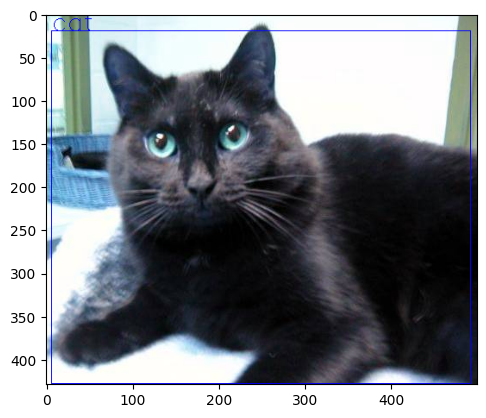

In [219]:
path = "Dataset/SSD/cat.174.jpg"
image = read_image(path)
bboxes, scores, labels  = detect(prepare_image(image), thresh = 0.8)
img_pred = predicted(bboxes, scores, labels, image, True, True)

# Тест на видео

In [220]:
cap = cv2.VideoCapture(0) # 0 - link - camera or video
cap.set(3,640) 
cap.set(4,480) 
while True:
    success, img = cap.read()
    
    bboxes, scores, labels  = detect(prepare_image(img), thresh = 0.8)
    pred_image = predicted(bboxes, scores, labels, img)
   

    cv2.imshow("Webcam", pred_image) 
    if cv2.waitKey(1) & 0xFF==ord('q'): 
        cap.release()
        break


cap.release()       
cv2.destroyAllWindows() 
cv2.waitKey(1)

-1

In [226]:
image_path = "Dataset/SSD"
test_dir = image_path + "/cat/"


In [231]:
from pathlib import Path
test_data_paths = list(Path(test_dir).glob("*.jpg"))
test_data_paths[:5]
len(test_data_paths)


100

In [232]:
from timeit import default_timer as timer 

start_time = timer()
preds = []
pred_time = 0

with torch.no_grad():
    for path in test_data_paths:
        start_time = timer()

        image = read_image(str(path))
        bboxes, scores, labels  = detect(prepare_image(image), thresh = 0.8)
        img_pred = predicted(bboxes, scores, labels, image, draw = True)
        
        preds.append(img_pred)
        pred_time += round(timer() - start_time, 5)
print(pred_time / len(test_data_paths))


0.05308089999999998


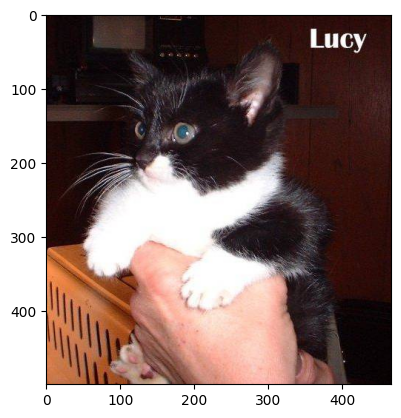

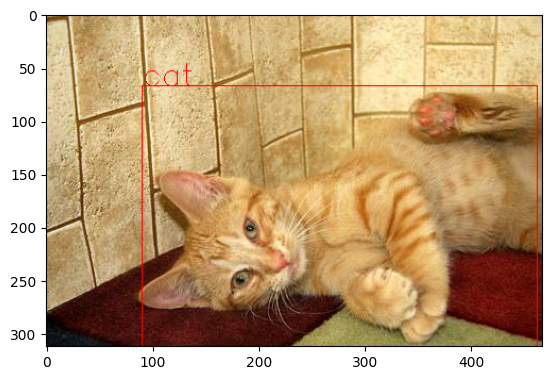

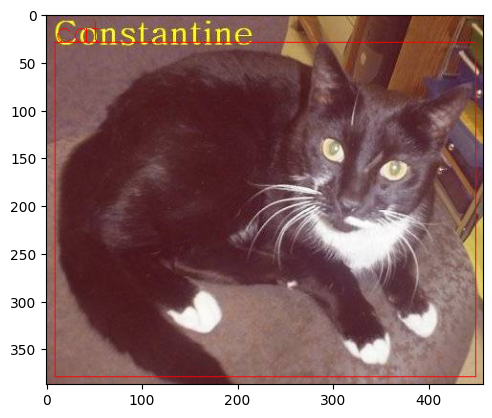

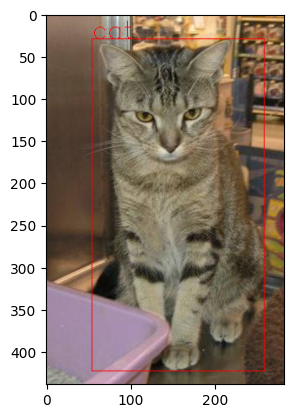

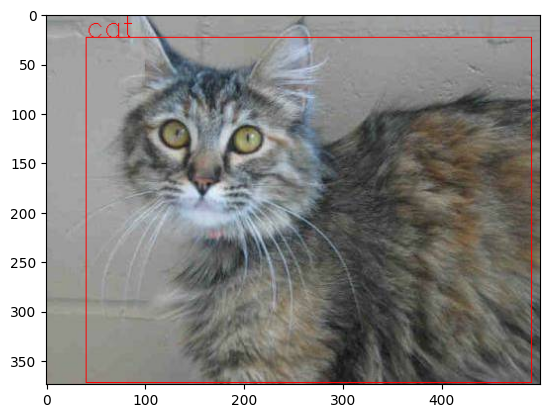

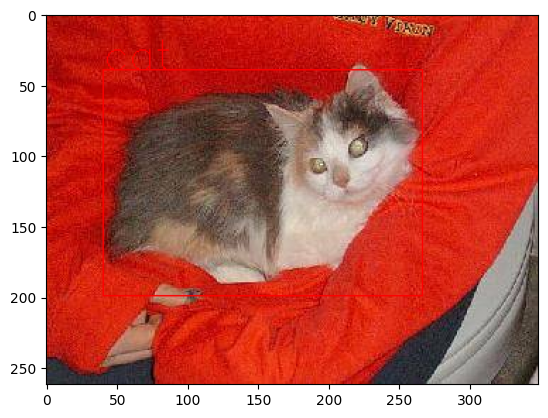

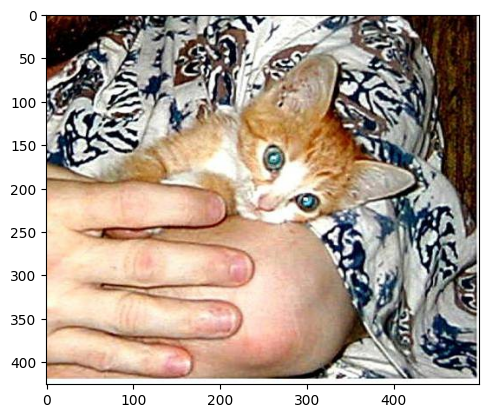

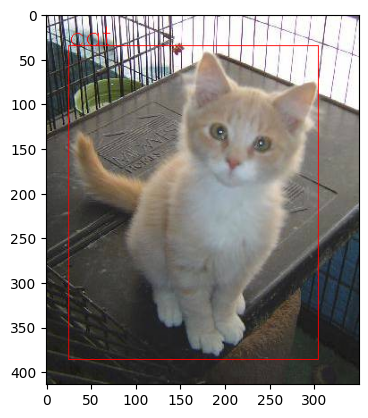

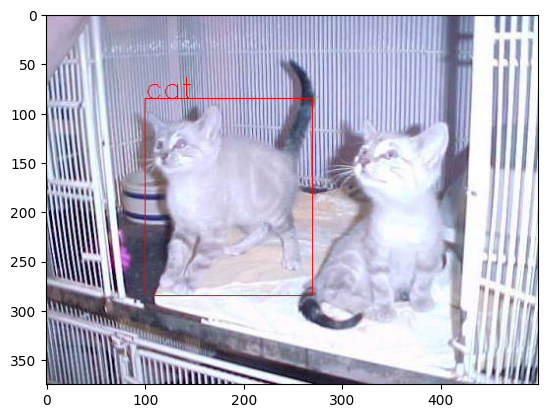

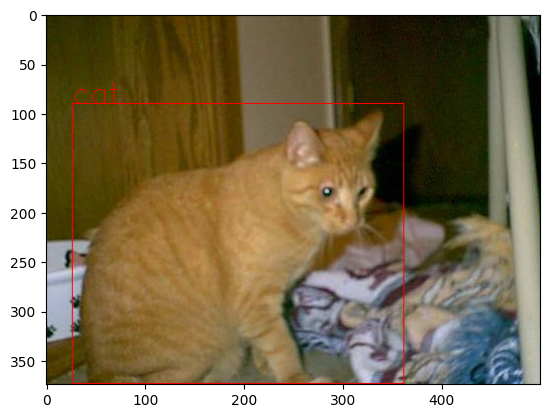

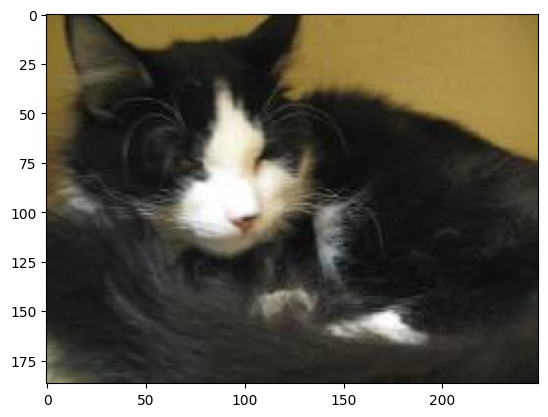

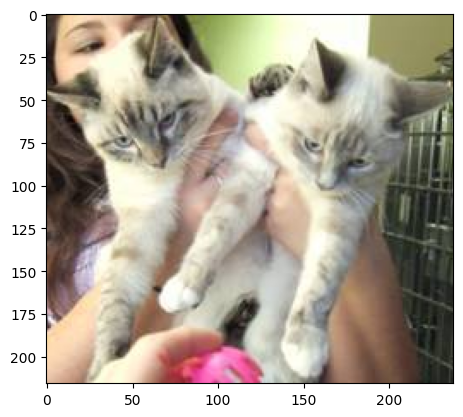

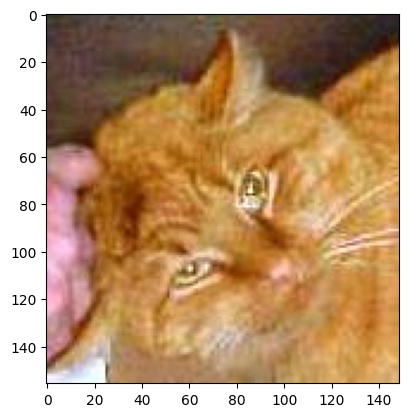

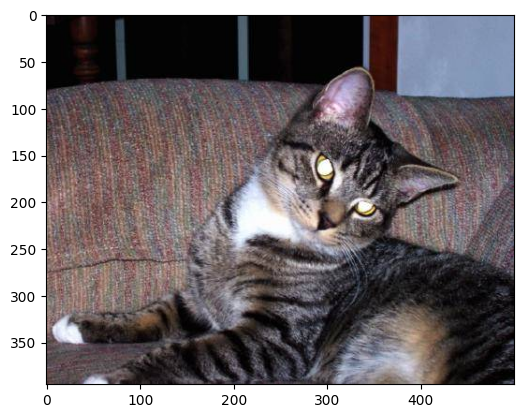

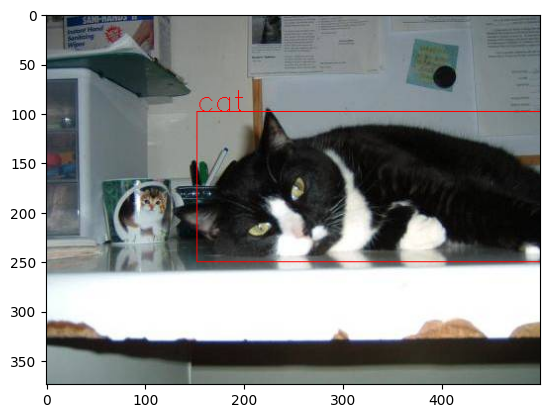

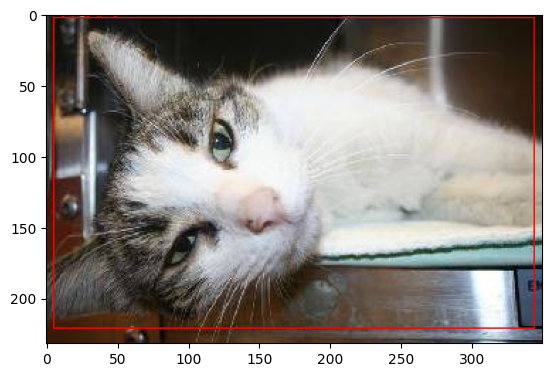

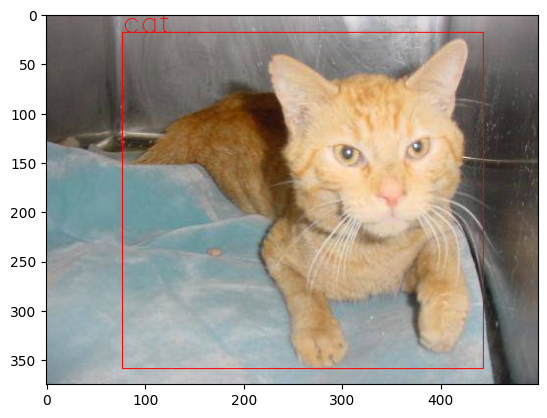

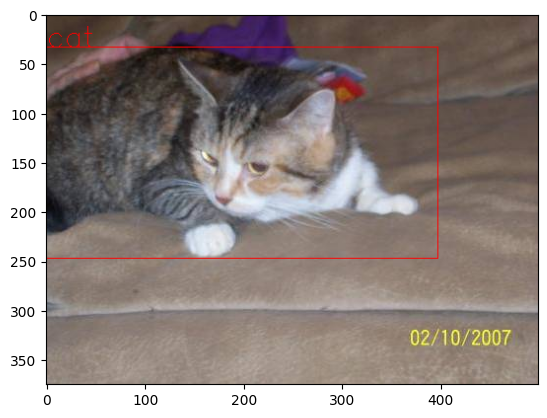

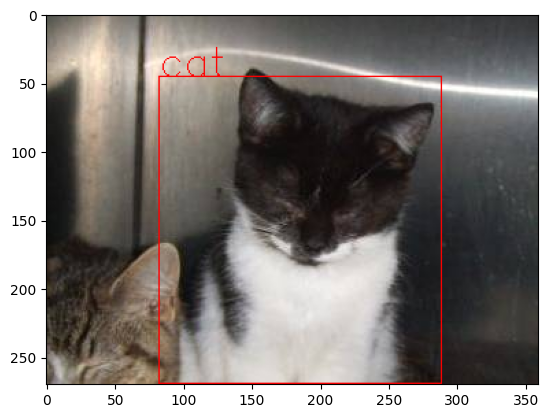

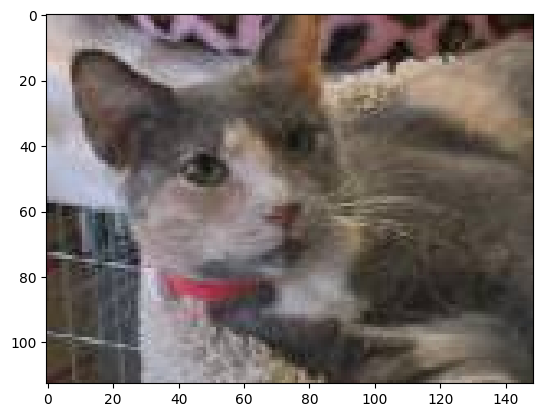

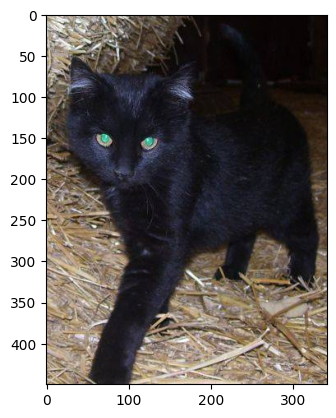

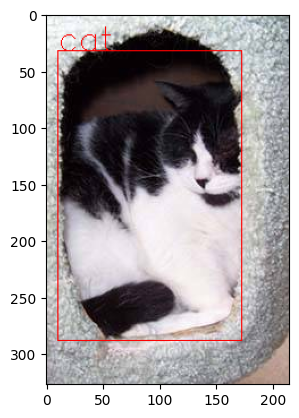

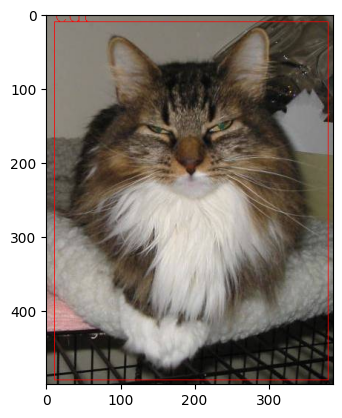

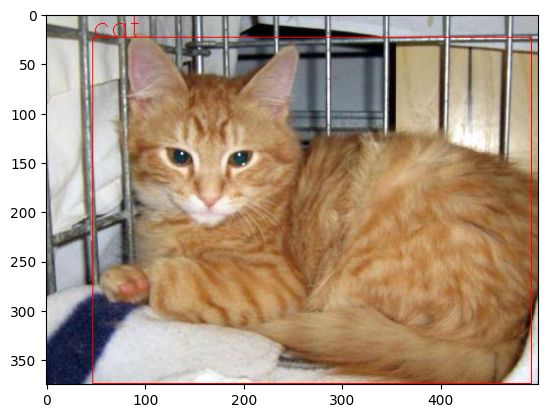

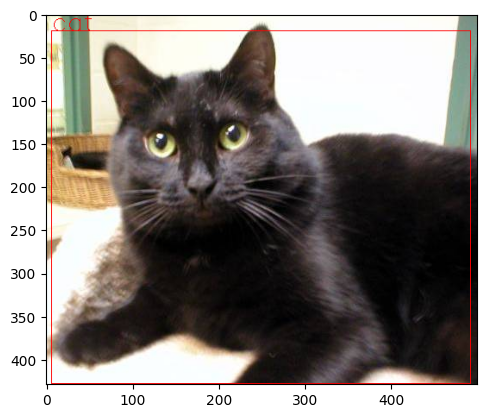

In [233]:
for i in range(25):
    img = cv2.cvtColor(preds[i], cv2.COLOR_RGB2BGR)
    plt.imshow(img)
    plt.show()